In [62]:
# import necessary libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

# load the dataset
data = pd.read_csv(r'C:\Users\Z3TAR\Documents\Python\Customer Segmentation\Sample - Superstore.csv', encoding="ISO-8859-1")

In [ ]:
# Preprocess the data

# Drop rows with missing 'Customer ID'
data = data.dropna(subset=['Customer ID'])
# Convert 'Customer ID' to string type for consistency
data['Customer ID'] = data['Customer ID'].astype(str)
# Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])
data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [64]:
# Create boxplots for 'Quantity' and 'Sales' using Plotly
fig = make_subplots(rows=1, cols=2)

# Add a vertical boxplot for 'Quantity' in the first column
fig.add_trace(go.Box(y=data['Quantity'], name='Quantity'), row=1, col=1)

# Add a vertical boxplot for 'UnitPrice' in the second column
fig.add_trace(go.Box(y=data['Sales'], name='Sales'), row=1, col=2)

# Update the layout
fig.update_layout(
    title='Boxplots for Quantity and Unit Price',
    height=400,
    width=800
)

# Show the plot
fig.show()

In [65]:
# Calculate statistics for Quantity
Q1_quantity = data['Quantity'].quantile(0.25)
Q3_quantity = data['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

# Print summary of potential outliers
print("Quantity Statistics:")
print(f"Values below: {Q1_quantity - 1.5*IQR_quantity}")
print(f"Values above: {Q3_quantity + 1.5*IQR_quantity}")
print(f"Number of potential outliers: {len(data[data['Quantity'] > Q3_quantity+ 1.5*IQR_quantity])}")

Quantity Statistics:
Values below: -2.5
Values above: 9.5
Number of potential outliers: 170


In [66]:
# Function to remove outliers from a column
def remove_outliers(df, column):
    # Calculate IQR and define bounds for outliers
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# Apply the function to each numeric column
for column in data.select_dtypes(include='number').columns:
    data = remove_outliers(data, column)

In [67]:
# Create boxplots for 'Quantity' and 'Sales' using Plotly
fig = make_subplots(rows=1, cols=2)

# Add a vertical boxplot for 'Quantity' in the first column
fig.add_trace(go.Box(y=data['Quantity'], name='Quantity'), row=1, col=1)

# Add a vertical boxplot for 'UnitPrice' in the second column
fig.add_trace(go.Box(y=data['Sales'], name='Sales'), row=1, col=2)

# Update the layout
fig.update_layout(
    title='Boxplots for Quantity and Unit Price',
    height=400,
    width=800
)

# Show the plot
fig.show()

In [68]:
# --Group data by Customer ID--

# Calculating the total sum for each transaction
data['Total'] = data['Sales']*data['Quantity']

# Setting the snapshot date to the day after the last transaction
snapshot_date = data['Order Date'].max() + timedelta(days=1)
print(snapshot_date)

# Aggregating data per customer
data_process = data.groupby(['Customer ID']).agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days, #Calculate recency as days since last purchase
    'Order ID': 'nunique',  #Count the unique number of invoices as frequency
    'Total': 'sum' #Sum the total monetary value of purchases
})

#Renaming columns to more descriptive names for RFM analysis
data_process.rename(columns={'Order Date': 'Recency',
                         'Order ID': 'Frequency',
                         'Total': 'Monetary'}, inplace=True)

# Rounding the results
data_process = data_process.astype(int)
data_process

2017-12-31 00:00:00


,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,185,5,1847
AA-10375,20,9,1734
AA-10480,260,4,1632
AA-10645,56,6,2250
AB-10015,1395,2,856
...,...,...,...
XP-21865,44,11,4431
YC-21895,481,3,1567
YS-21880,135,5,3321


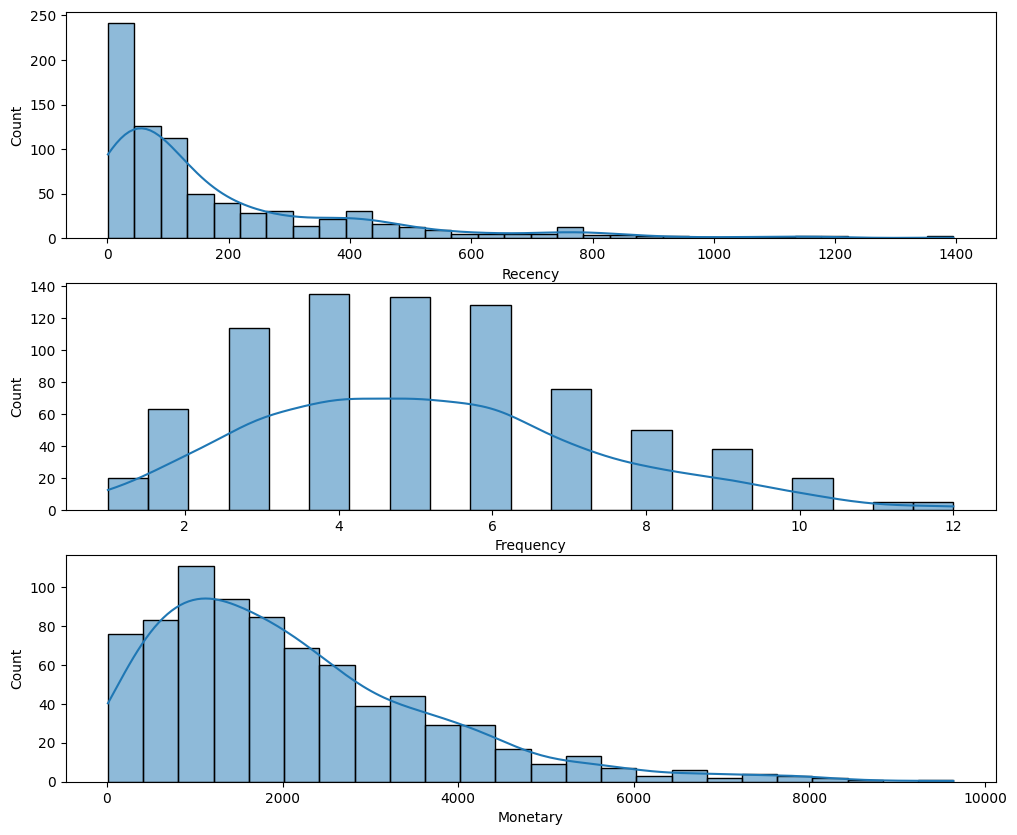

In [69]:
# Plot RFM distributions
plt.figure(figsize=(12,10))

# Plot distribution of R
plt.subplot(3, 1, 1)
sns.histplot(data_process['Recency'], kde=True)

# Plot distribution of F
plt.subplot(3, 1, 2)
sns.histplot(data_process['Frequency'], kde=True)

# Plot distribution of M
plt.subplot(3, 1, 3)
sns.histplot(data_process['Monetary'], kde=True)

# Show the plot
plt.show()

In [70]:
# Define the feature columns to be standardized.
feature_cols = ['Recency','Frequency','Monetary']

#Create a copy of the dataframe to hold the standardized values. This ensures the original data is not modified.
standardized_data = data_process.copy()

#Initialize the StandardScaler
scaler = StandardScaler()

#Compute the mean and standard deviation for scaling later, using only the feature columns specified earlier.
scaler.fit(data_process[feature_cols])

#Perform standardization by centering and scaling, based on the mean and standard deviation computed above.
standardized_features = scaler.transform(data_process[feature_cols])

#Update the original dataframe with the standardized values for the feature columns.
standardized_data[feature_cols] = standardized_features

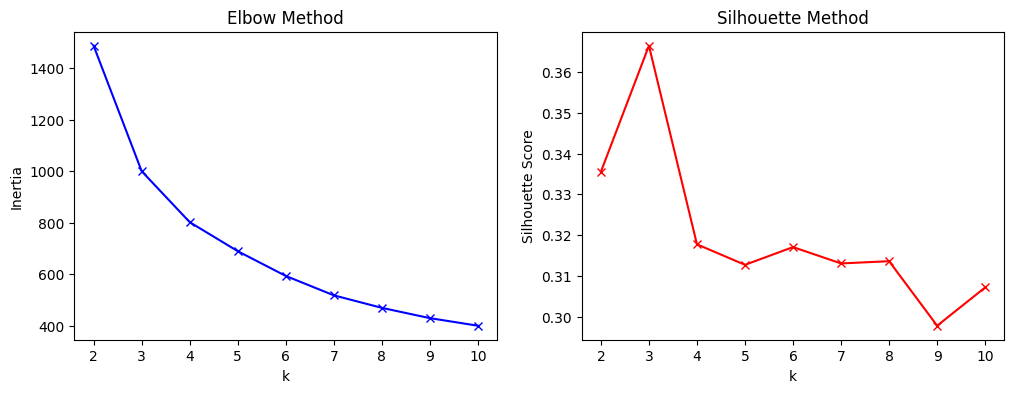

In [71]:
# Fit KMeans clustering for a range of k values and calculate inertia and silhouette scores


# Initialize lists to hold silhouette scores and inertias
sil_scores = []
inertias = []
K_range = range(2,11)

# Loop through the range of k values to fit KMeans and calculate inertia and silhouette scores
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(standardized_data[feature_cols])
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(standardized_data[feature_cols], labels))


# Plotting the results of the Elbow and Silhouette methods

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot
ax1.plot(K_range, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

# Silhouette plot
ax2.plot(K_range, sil_scores, 'rx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Method')

plt.show()


In [72]:
# Fit KMeans with the optimal number of clusters (k=3 in this case)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,  # This can be set to define the maximum number of iterations
    "random_state": 42  # Set the random state for reproducibility
}

kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(standardized_data[feature_cols])

# Add 1 to each label to change cluster numbering from 1
data_process['cluster'] = kmeans.labels_ + 1

# Reset the index of the DataFrame so 'Customer ID' becomes a regular column
data_process = data_process.reset_index()

# Group by cluster and calculate means and counts
centroid_df = data_process.groupby('cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'nunique'
}).reset_index()

# Rename the 'CustomerID' column to 'NumCustomers'
centroid_df = centroid_df.rename(columns={'Customer ID': 'No. Customers'})

# Sort by 'Frequency' in descending order
centroid_df = centroid_df.sort_values(by='Frequency', ascending=False)

# Add a new column 'MapCluster' based on frequency quartiles
centroid_df['MapCluster'] = pd.qcut(centroid_df['Frequency'], 3, labels=[1, 2, 3])

# Convert 'MapCluster' to integer type
centroid_df['MapCluster'] = centroid_df['MapCluster'].astype(int)

# Merge centroid_df with data_process to add 'MapCluster'
data_process = data_process.merge(centroid_df[['cluster', 'MapCluster']], on='cluster', how='left').reset_index(drop=True)

In [73]:
# Assigning cluster names to the centroids in the dataframe
cluster_names = ['Platinum', 'Gold', 'Silver']
# Adds a new column 'ClusterName' to centroid_df with the provided names
centroid_df['ClusterName'] = cluster_names
# Display the dataframe with the new 'ClusterName' column
centroid_df

,cluster,Recency,Frequency,Monetary,No. Customers,MapCluster,ClusterName
0,1,100.616279,7.406977,3770.104651,258,3,Platinum
2,3,112.645631,4.361650,1361.111650,412,2,Gold
1,2,623.692308,2.923077,1192.777778,117,1,Silver


In [74]:
# Creating a 3D scatter plot for RFM segmentation with color mapping for different RFM levels.
fig = px.scatter_3d(centroid_df, x='Recency', y='Frequency', z='Monetary',
              color='ClusterName', color_discrete_map={"Platinum": "blue", "Gold": "gold", "Silver": "darkgrey", "Bronze": "brown"},
              title="RFM Segmentation")
fig.show()  # Displays the plot in an interactive window.